In [1]:
import difflib
import math
import random
import string
random.seed(123)

import gluonnlp
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import mxnet as mx
import numpy as np
from skimage import transform as skimage_tf
from utils.iam_dataset import IAMDataset, resize_image, crop_image, crop_handwriting_page
from tqdm import tqdm
from utils.expand_bounding_box import expand_bounding_box
from utils.sclite_helper import Sclite_helper
from utils.word_to_line import sort_bbs_line_by_line, crop_line_images

from paragraph_segmentation_dcnn import make_cnn as ParagraphSegmentationNet, paragraph_segmentation_transform
from word_segmentation import SSD as WordSegmentationNet, predict_bounding_boxes
from handwriting_line_recognition import Network as HandwritingRecognitionNet, handwriting_recognition_transform
from handwriting_line_recognition import decode as decoder_handwriting, alphabet_encoding

In [2]:
ctx = mx.gpu(0)

## Dataset creation
Obtain the original forms from the IAM dataset and plot the results. Randomly select 4 images for analysis.

In [3]:
test_ds = IAMDataset("form_original", train=False)

In [4]:
figs_to_plot = 4
images = []

for i in range(0, figs_to_plot):
    n = int(random.random()*len(test_ds))
    image, _ = test_ds[n]
    images.append(image)

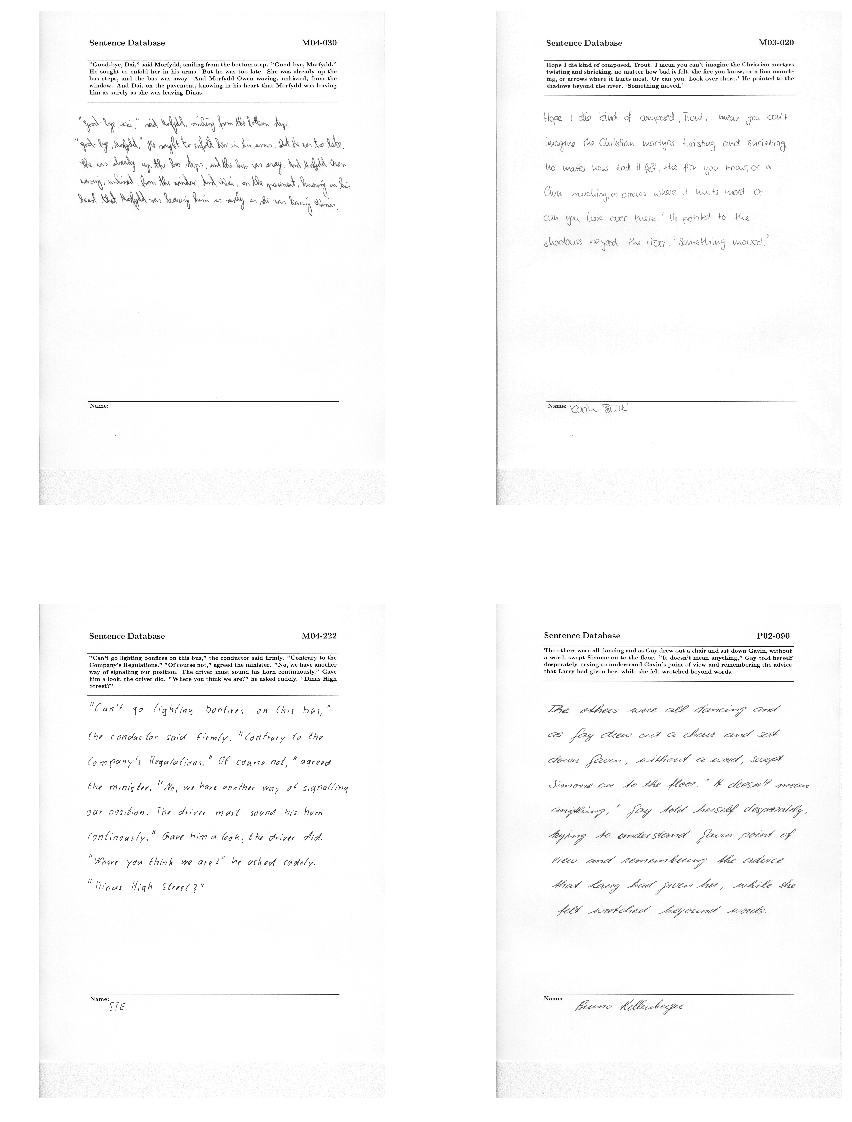

In [5]:
fig, axs = plt.subplots(int(len(images)/2), 2, figsize=(15, 10 * len(images)/2))
for i, image in enumerate(images):
    y, x = int(i/2), int(i%2)
    axs[y, x].imshow(image, cmap='Greys_r')
    axs[y, x].axis('off')

## Paragraph segmentation
Given the image of a form in the IAM dataset, predict a bounding box of the handwriten component. The model was trained on using https://github.com/ThomasDelteil/Gluon_OCR_LSTM_CTC/blob/master/paragraph_segmentation_dcnn.py and an example is presented in https://github.com/ThomasDelteil/Gluon_OCR_LSTM_CTC/blob/master/paragraph_segmentation_dcnn.ipynb

In [6]:
paragraph_segmentation_net = ParagraphSegmentationNet()
paragraph_segmentation_net.load_parameters("models/paragraph_segmentation2.params")

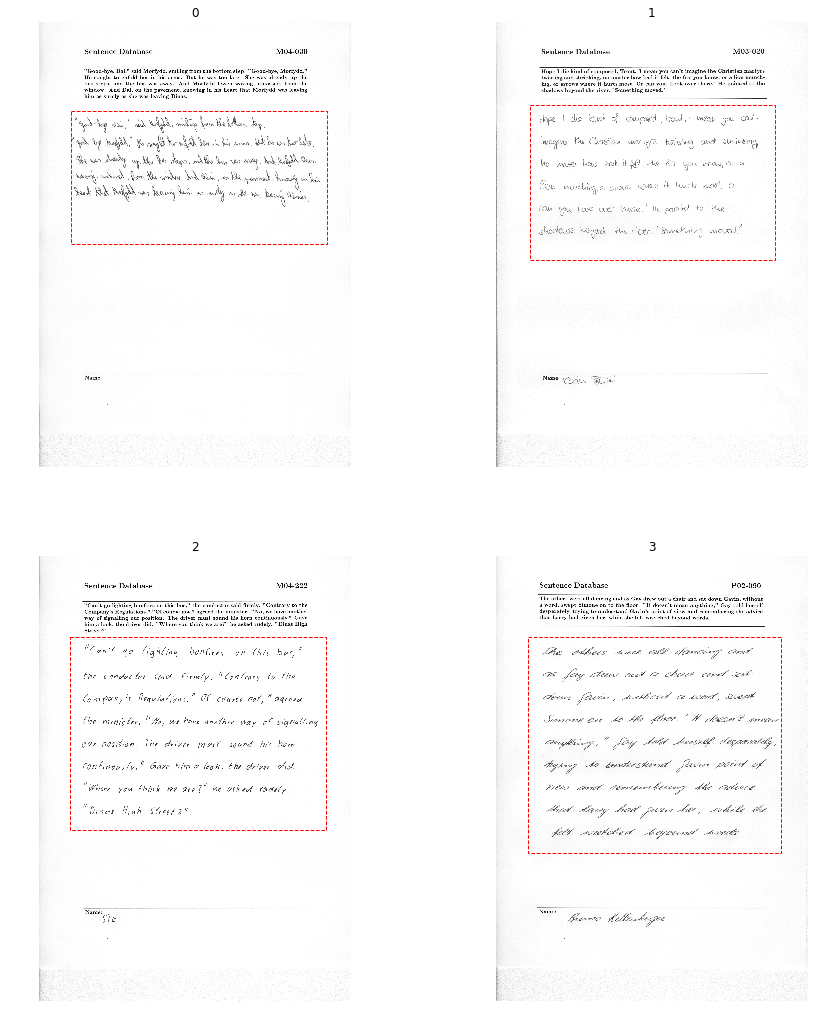

In [7]:
form_size = (1120, 800)

predicted_bbs = []

fig, axs = plt.subplots(int(len(images)/2), 2, figsize=(15, 9 * len(images)/2))
for i, image in enumerate(images):
    s_y, s_x = int(i/2), int(i%2)
    resized_image = paragraph_segmentation_transform(image, form_size)
    bb_predicted = paragraph_segmentation_net(resized_image.as_in_context(ctx))
    bb_predicted = bb_predicted[0].asnumpy()
    bb_predicted = expand_bounding_box(bb_predicted, expand_bb_scale_x=0.05,
                                           expand_bb_scale_y=0.07)
    predicted_bbs.append(bb_predicted)
    
    axs[s_y, s_x].imshow(image, cmap='Greys_r')
    axs[s_y, s_x].set_title("{}".format(i))

    (x, y, w, h) = bb_predicted
    image_h, image_w = image.shape[-2:]
    (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)
    rect = patches.Rectangle((x, y), w, h, fill=False, color="r", ls="--")
    axs[s_y, s_x].add_patch(rect)
    axs[s_y, s_x].axis('off')

#### Image processing
Crop the handwriting component out of the original IAM form.

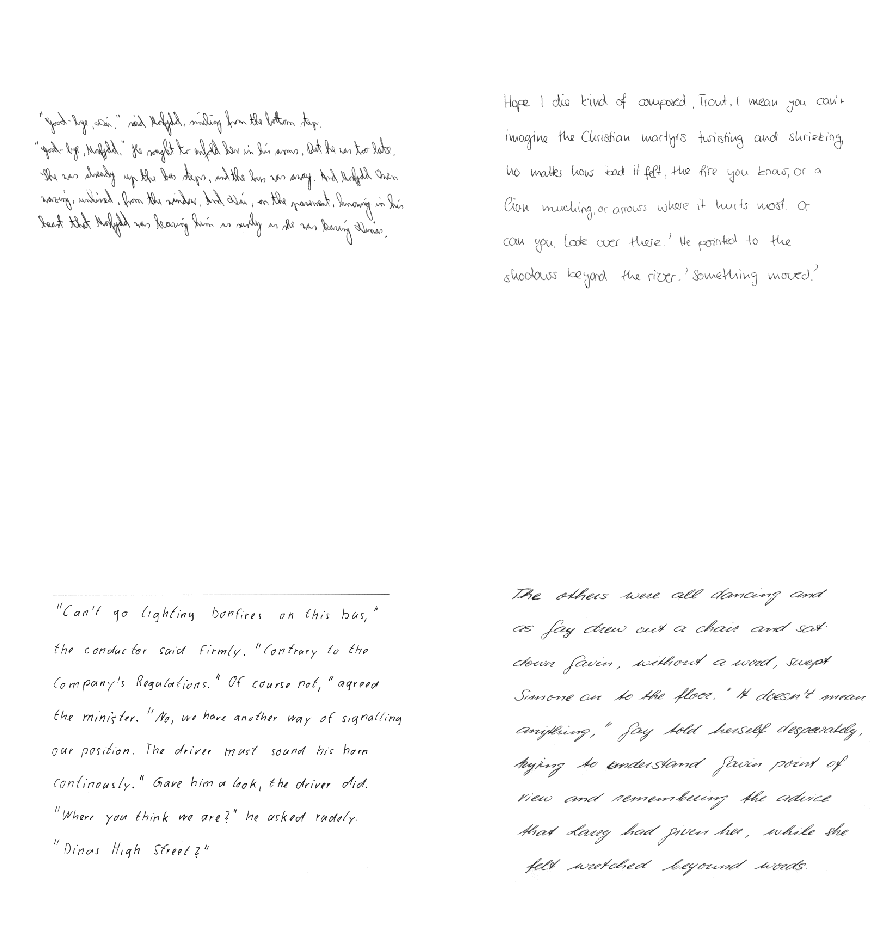

In [8]:
segmented_paragraph_size = (700, 700)
fig, axs = plt.subplots(int(len(images)/2), 2, figsize=(15, 9 * len(images)/2))

paragraph_segmented_images = []

for i, image in enumerate(images):
    s_y, s_x = int(i/2), int(i%2)

    bb = predicted_bbs[i]
    image = crop_handwriting_page(image, bb, image_size=segmented_paragraph_size)
    paragraph_segmented_images.append(image)
    
    axs[s_y, s_x].imshow(image, cmap='Greys_r')
    axs[s_y, s_x].axis('off')

## Line/word segmentation
Given a form with only handwritten text, predict a bounding box for each word. The model was trained with https://github.com/ThomasDelteil/Gluon_OCR_LSTM_CTC/blob/language_model/word_segmentation.py

In [9]:
word_segmentation_net = WordSegmentationNet(2, ctx=ctx)
word_segmentation_net.load_parameters("models/word_segmentation2.params")

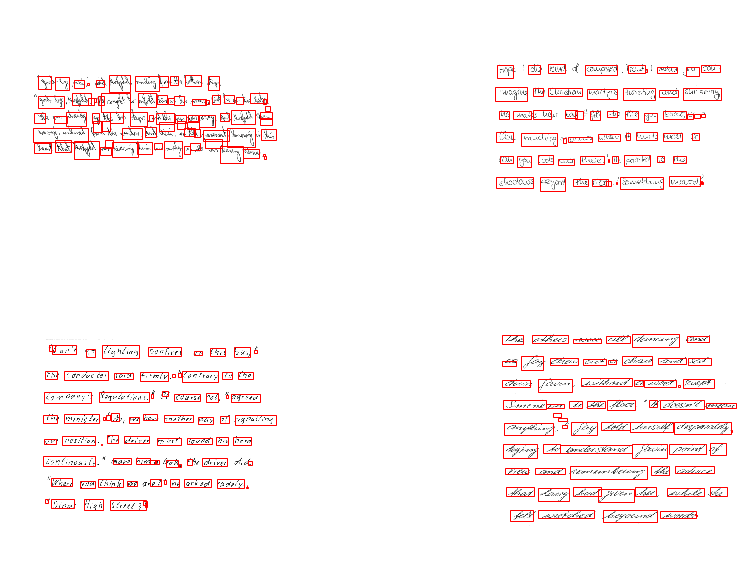

In [10]:
min_c = 0.1
overlap_thres = 0.1
topk = 600

fig, axs = plt.subplots(int(len(paragraph_segmented_images)/2), 2, 
                        figsize=(15, 5 * int(len(paragraph_segmented_images)/2)))
predicted_words_bbs_array = []

for i, paragraph_segmented_image in enumerate(paragraph_segmented_images):
    s_y, s_x = int(i/2), int(i%2)

    predicted_bb = predict_bounding_boxes(
        word_segmentation_net, paragraph_segmented_image, min_c, overlap_thres, topk, ctx)

    predicted_words_bbs_array.append(predicted_bb)
    
    axs[s_y, s_x].imshow(paragraph_segmented_image, cmap='Greys_r')
    for j in range(predicted_bb.shape[0]):     
        (x, y, w, h) = predicted_bb[j]
        image_h, image_w = paragraph_segmented_image.shape[-2:]
        (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)
        rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
        axs[s_y, s_x].add_patch(rect)
        axs[s_y, s_x].axis('off')

#### Word to line image processing
Algorithm to sort then group all words within a line together.

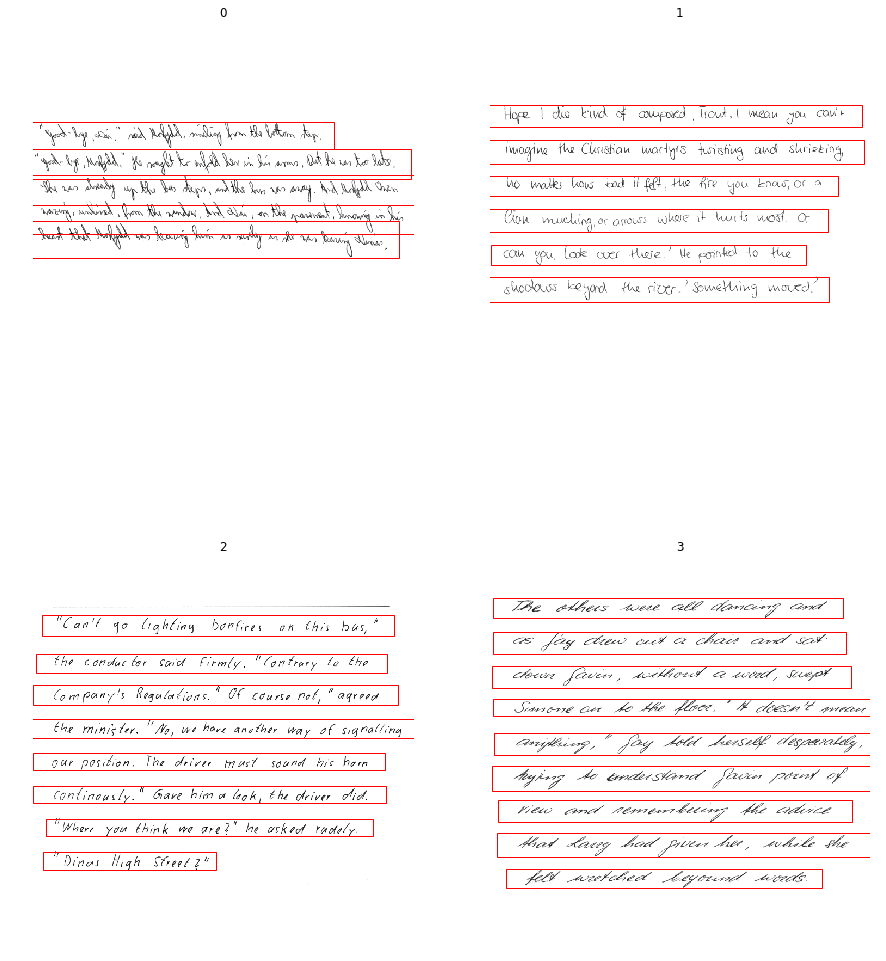

In [11]:
line_images_array = []
fig, axs = plt.subplots(int(len(paragraph_segmented_images)/2), 2, 
                        figsize=(15, 9 * int(len(paragraph_segmented_images)/2)))

for i, paragraph_segmented_image in enumerate(paragraph_segmented_images):
    s_y, s_x = int(i/2), int(i%2)
    axs[s_y, s_x].imshow(paragraph_segmented_image, cmap='Greys_r')
    axs[s_y, s_x].axis('off')
    axs[s_y, s_x].set_title("{}".format(i))
    
    predicted_bbs = predicted_words_bbs_array[i]
    line_bbs = sort_bbs_line_by_line(predicted_bbs, y_overlap=0.4)
    line_images = crop_line_images(paragraph_segmented_image, line_bbs)
    line_images_array.append(line_images)
    
    for line_bb in line_bbs:
        (x, y, w, h) = line_bb
        image_h, image_w = paragraph_segmented_image.shape[-2:]
        (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)

        rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
        axs[s_y, s_x].add_patch(rect)

# Handwriting recognition
Given each line of text, predict a string of the handwritten text. This network was trained with https://github.com/ThomasDelteil/Gluon_OCR_LSTM_CTC/blob/language_model/handwriting_line_recognition.py

In [12]:
handwriting_line_recognition_net = HandwritingRecognitionNet(rnn_hidden_states=512,
                                                             rnn_layers=2, ctx=ctx, max_seq_len=160)
handwriting_line_recognition_net.load_parameters("models/handwriting_line_sl_160_a_512_o_2.params")

In [13]:
line_image_size = (60, 800)
character_probs = []
for line_images in line_images_array:
    form_character_prob = []
    for i, line_image in enumerate(line_images):
        line_image = handwriting_recognition_transform(line_image, line_image_size)
        line_character_prob = handwriting_line_recognition_net(line_image.as_in_context(ctx))
        form_character_prob.append(line_character_prob)
    character_probs.append(form_character_prob)

### Language model

In [14]:
from utils.CTCDecoder.BeamSearch import ctcBeamSearch
from utils.CTCDecoder.LanguageModel import LanguageModel

In [15]:
def get_arg_max(prob):
    '''
    The greedy algorithm convert the output of the handwriting recognition network
    into strings.
    '''
    arg_max = prob.topk(axis=2).asnumpy()
    return decoder_handwriting(arg_max)[0]

In [16]:
def get_beam_search(prob, width=20, k=4):
    possibilities = ctcBeamSearch(prob.softmax()[0].asnumpy(), alphabet_encoding, None, width, k)
    return possibilities[0]

In [17]:
def get_beam_search_with_lm(prob, width=20, k=4):
    lm = LanguageModel('dataset/alicewonder.txt', alphabet_encoding)
    possibilities = ctcBeamSearch(prob.softmax()[0].asnumpy(), alphabet_encoding, lm, width, k)
    return possibilities[0]

# Qualitative results
The handwriting is recognised for the four randomly selected forms. The results from the three methods: no language model, lexicon search, and beam search are presented.

#### No language model

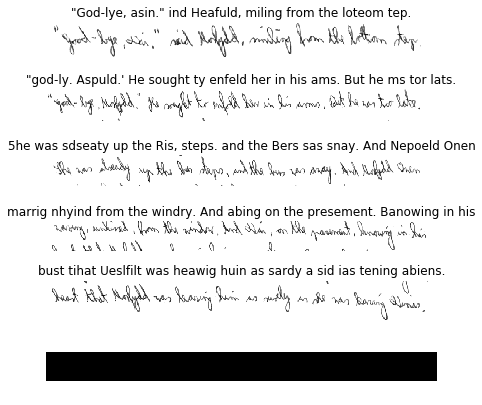

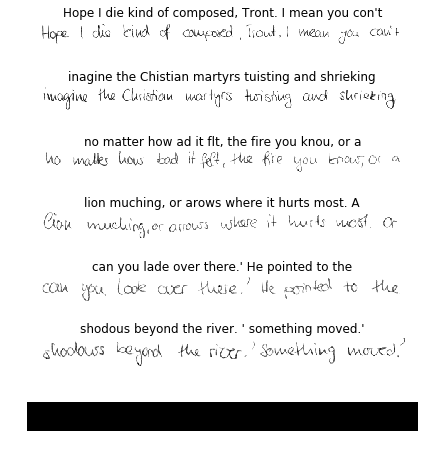

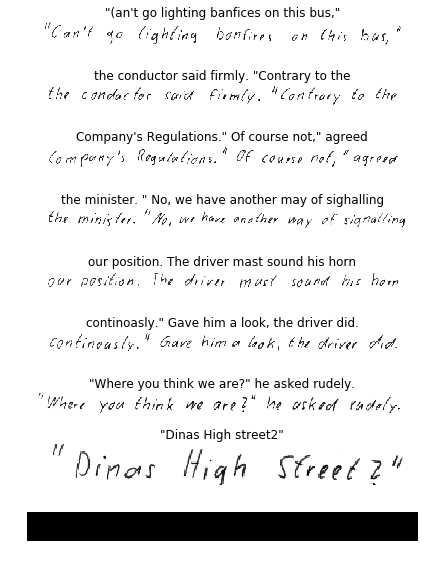

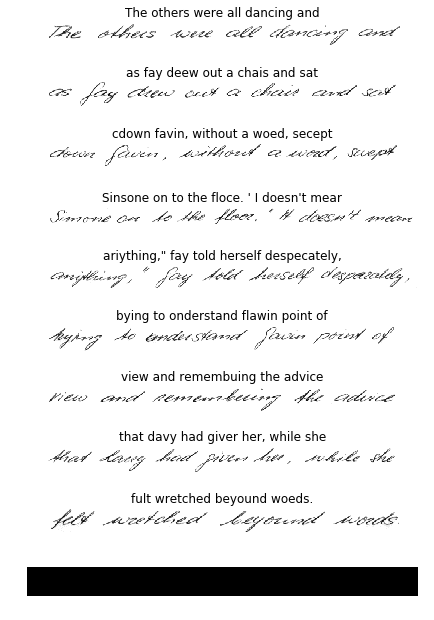

In [18]:
for i, form_character_probs in enumerate(character_probs):
    fig, axs = plt.subplots(len(form_character_probs) + 1, 
                            figsize=(7, int(1 + 1.2 * len(form_character_probs))))
    for j, line_character_probs in enumerate(form_character_probs):
        decoded_line = get_arg_max(line_character_probs)
        line_image = line_images_array[i][j]
        axs[j].imshow(line_image.squeeze(), cmap='Greys_r')            
        axs[j].imshow(line_image.squeeze(), cmap='Greys_r')
        axs[j].set_title("{}".format(decoded_line))
        axs[j].axis('off')
    axs[-1].imshow(np.zeros(shape=line_image_size), cmap='Greys_r')
    axs[-1].axis('off')

### Adding Beam Search inference

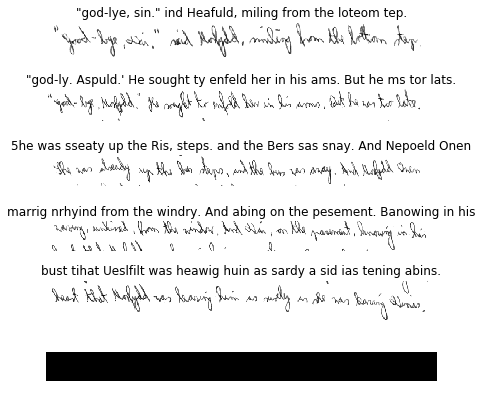

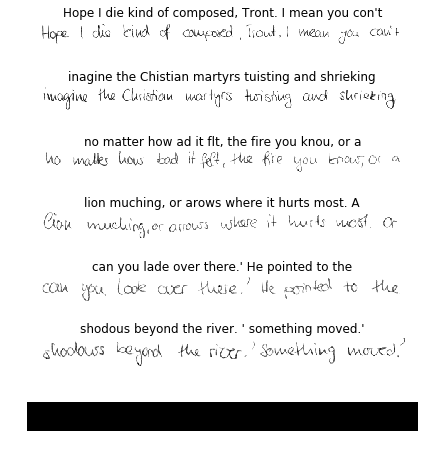

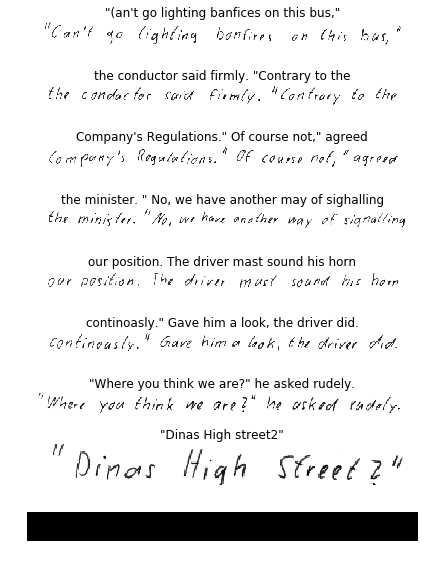

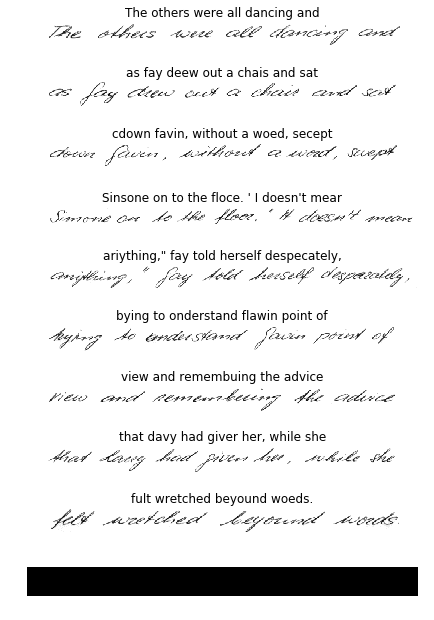

In [19]:
for i, form_character_probs in enumerate(character_probs):
    fig, axs = plt.subplots(len(form_character_probs) + 1, 
                            figsize=(7, int(1 + 1.2 * len(form_character_probs))))
    for j, line_character_probs in enumerate(form_character_probs):
        decoded_line = get_beam_search(line_character_probs)
        line_image = line_images_array[i][j]
        axs[j].imshow(line_image.squeeze(), cmap='Greys_r')            
        axs[j].imshow(line_image.squeeze(), cmap='Greys_r')
        axs[j].set_title("{}".format(decoded_line))
        axs[j].axis('off')
    axs[-1].imshow(np.zeros(shape=line_image_size), cmap='Greys_r')
    axs[-1].axis('off')

### Adding Beam Search inference + Language Model

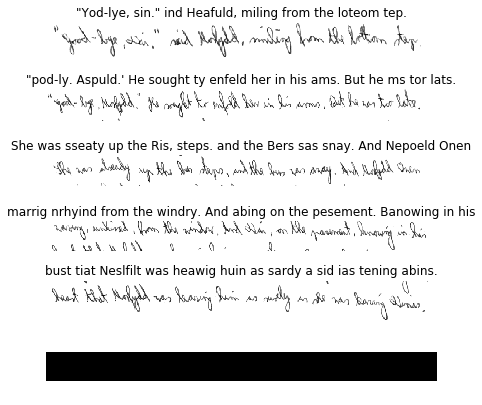

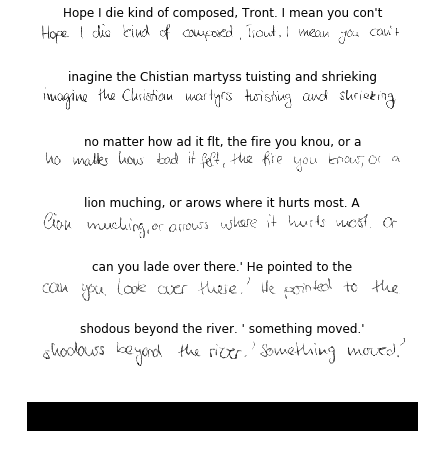

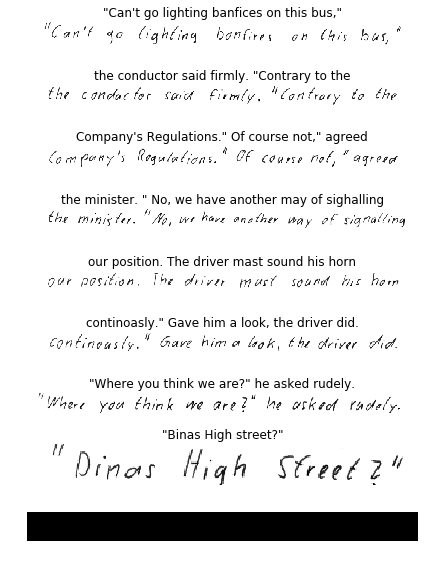

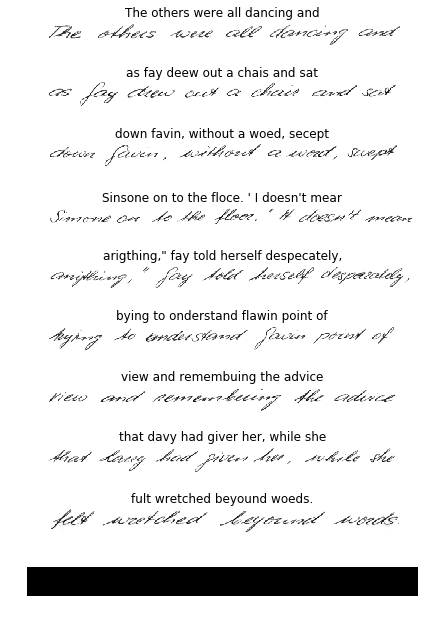

In [24]:
for i, form_character_probs in enumerate(character_probs):
    fig, axs = plt.subplots(len(form_character_probs) + 1, 
                            figsize=(7, int(1 + 1.2 * len(form_character_probs))))
    for j, line_character_probs in enumerate(form_character_probs):
        decoded_line = get_beam_search_with_lm(line_character_probs)
        line_image = line_images_array[i][j]
        axs[j].imshow(line_image.squeeze(), cmap='Greys_r')            
        axs[j].imshow(line_image.squeeze(), cmap='Greys_r')
        axs[j].set_title("{}".format(decoded_line))
        axs[j].axis('off')
    axs[-1].imshow(np.zeros(shape=line_image_size), cmap='Greys_r')
    axs[-1].axis('off')

# Quantitative Results
Iterative through the test data with the previous tests to obtain the total Character Error Rate (CER).

In [21]:
sclite = Sclite_helper()

def get_qualitative_results(denoise_func):
    sclite.clear()
    for i in tqdm(range(len(test_ds))):
        image, text = test_ds[i]
        resized_image = paragraph_segmentation_transform(image, image_size=(1120, 800))
        paragraph_bb = paragraph_segmentation_net(resized_image.as_in_context(ctx))
        paragraph_segmented_image = crop_handwriting_page(image, paragraph_bb[0].asnumpy(), image_size=(700, 700))
        word_bb = predict_bounding_boxes(word_segmentation_net, paragraph_segmented_image, min_c, overlap_thres, topk, ctx)        
        line_bbs = sort_bbs_line_by_line(word_bb, y_overlap=0.4)
        line_images = crop_line_images(paragraph_segmented_image, line_bbs)

        predicted_text = []
        for line_image in line_images:
            line_image = handwriting_recognition_transform(line_image, line_image_size)
            character_probabilities = handwriting_line_recognition_net(line_image.as_in_context(ctx))
            decoded_text = denoise_func(character_probabilities)
            predicted_text.append(decoded_text)

        actual_text = text[0].replace("&quot", '\"').replace("&amp", "&").replace('";', '\"')[:-1]
        actual_text = actual_text.split("\n")
        if len(predicted_text) > len(actual_text):
            predicted_text = predicted_text[:len(actual_text)]
        sclite.add_text(predicted_text, actual_text)
    
    _, er = sclite.get_cer()
    print("Mean CER = {}".format(er))

In [22]:
get_qualitative_results(get_arg_max)

100%|██████████| 232/232 [01:23<00:00,  2.67it/s]


Mean CER = 10.599999999999994


In [23]:
get_qualitative_results(get_beam_search)

100%|██████████| 232/232 [13:39<00:00,  3.64s/it]


Mean CER = 10.5


In [25]:
get_qualitative_results(get_beam_search_with_lm)

100%|██████████| 232/232 [17:55<00:00,  4.76s/it]


Mean CER = 10.900000000000006
